In [1]:
import tensorflow as tf
from tensorflow import keras
from keras import layers
import matplotlib.pyplot as plt
import datetime


In [2]:
%load_ext tensorboard
import os

os.system('rm -rf ./logs/')

1

In [3]:
tf.get_logger().setLevel('ERROR')

In [4]:
from src.load_dataset.load_dataset import x_test, y_test, x_train, y_train, classes
from tensorflow.keras.applications import MobileNetV2

In [5]:
conv_base = MobileNetV2(weights='imagenet', include_top=False, input_shape=(96, 96, 3))
conv_base.trainable = False

In [6]:
model = keras.Sequential([
    layers.Input(shape=(32, 32, 3)),
    layers.Rescaling(1. / 255),
    layers.Resizing(96, 96),
    conv_base,
    layers.Flatten(),
    layers.Dense(128, activation="relu"),
    layers.Dropout(0.5),
    layers.Dense(256, activation="relu"),
    layers.Dropout(0.5),
    layers.Dense(10, activation="softmax")
])

In [7]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling (Rescaling)       (None, 32, 32, 3)         0         
                                                                 
 resizing (Resizing)         (None, 96, 96, 3)         0         
                                                                 
 mobilenetv2_1.00_96 (Functi  (None, 3, 3, 1280)       2257984   
 onal)                                                           
                                                                 
 flatten (Flatten)           (None, 11520)             0         
                                                                 
 dense (Dense)               (None, 128)               1474688   
                                                                 
 dropout (Dropout)           (None, 128)               0         
                                                        

In [8]:
log_dir = "logs/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)

callbacks = [
    keras.callbacks.ModelCheckpoint(
        "../models/mn_model.keras",
        save_best_only=True,
        monitor="val_loss",
        verbose=2),
    keras.callbacks.EarlyStopping(
        monitor="val_loss",
        patience=10,
        verbose=2
    ),
    tensorboard_callback
]


In [9]:
optimizer = keras.optimizers.RMSprop(learning_rate=0.001, decay=1e-6)
loss = keras.losses.SparseCategoricalCrossentropy()
metrics = ["accuracy"]

In [10]:
model.compile(optimizer=optimizer, loss=loss, metrics=metrics)

In [3]:
os.system('rm -rf ./logs/')

1

In [11]:
history = model.fit(x_train, y_train, epochs=50, batch_size=128, validation_split=0.2, callbacks=callbacks)

Epoch 1/50
313/313 [==============================] - ETA: 0s - loss: 1.6383 - accuracy: 0.4572
Epoch 1: val_loss improved from inf to 0.87089, saving model to ../models\mn_model.keras
313/313 [==============================] - 19s 35ms/step - loss: 1.6383 - accuracy: 0.4572 - val_loss: 0.8709 - val_accuracy: 0.7298
Epoch 2/50
312/313 [============================>.] - ETA: 0s - loss: 1.2183 - accuracy: 0.5856
Epoch 2: val_loss improved from 0.87089 to 0.75565, saving model to ../models\mn_model.keras
313/313 [==============================] - 10s 30ms/step - loss: 1.2180 - accuracy: 0.5857 - val_loss: 0.7556 - val_accuracy: 0.7637
Epoch 3/50
312/313 [============================>.] - ETA: 0s - loss: 1.0623 - accuracy: 0.6391
Epoch 3: val_loss did not improve from 0.75565
313/313 [==============================] - 9s 30ms/step - loss: 1.0621 - accuracy: 0.6392 - val_loss: 0.7806 - val_accuracy: 0.7644
Epoch 4/50
313/313 [==============================] - ETA: 0s - loss: 0.9830 - accura

In [18]:
model = tf.keras.models.load_model("../models/mn_model.keras")

model.evaluate(x_test, y_test)

313/313 [==============================] - 4s 9ms/step - loss: 0.6364 - accuracy: 0.8052


[0.6364271640777588, 0.8051999807357788]

In [19]:
import numpy as np


def visualize_predictions(model, n=15, rows=3):
    start = np.random.randint(0, len(x_test) - n)
    end = start + n
    to_predict = x_test[start:end]
    predicted = model.predict(to_predict)
    real = y_test[start:end]

    cols = (n + rows - 1) // rows

    print(f" Labels:      {real.T[0]}")
    print(f" Predictions: {np.argmax(predicted, axis=1)}")

    fig, axes = plt.subplots(rows, cols, figsize=(15, 3 * rows))

    for i in range(n):
        row = i // cols
        col = i % cols
        axes[row, col].imshow(to_predict[i])
        axes[row, col].set_title(f"predicted: {classes[np.argmax(predicted[i])]}\nreal label: {classes[real[i][0]]}")
        axes[row, col].axis('off')

    for i in range(n, rows * cols):
        fig.delaxes(axes.flatten()[i])

    plt.tight_layout()
    plt.show()


1/1 [==============================] - 1s 862ms/step
 Labels:      [0 1 3 1 4 2 3 8 4 2 3 7 8 4 3]
 Predictions: [0 1 3 1 4 2 3 8 4 3 3 7 8 6 2]


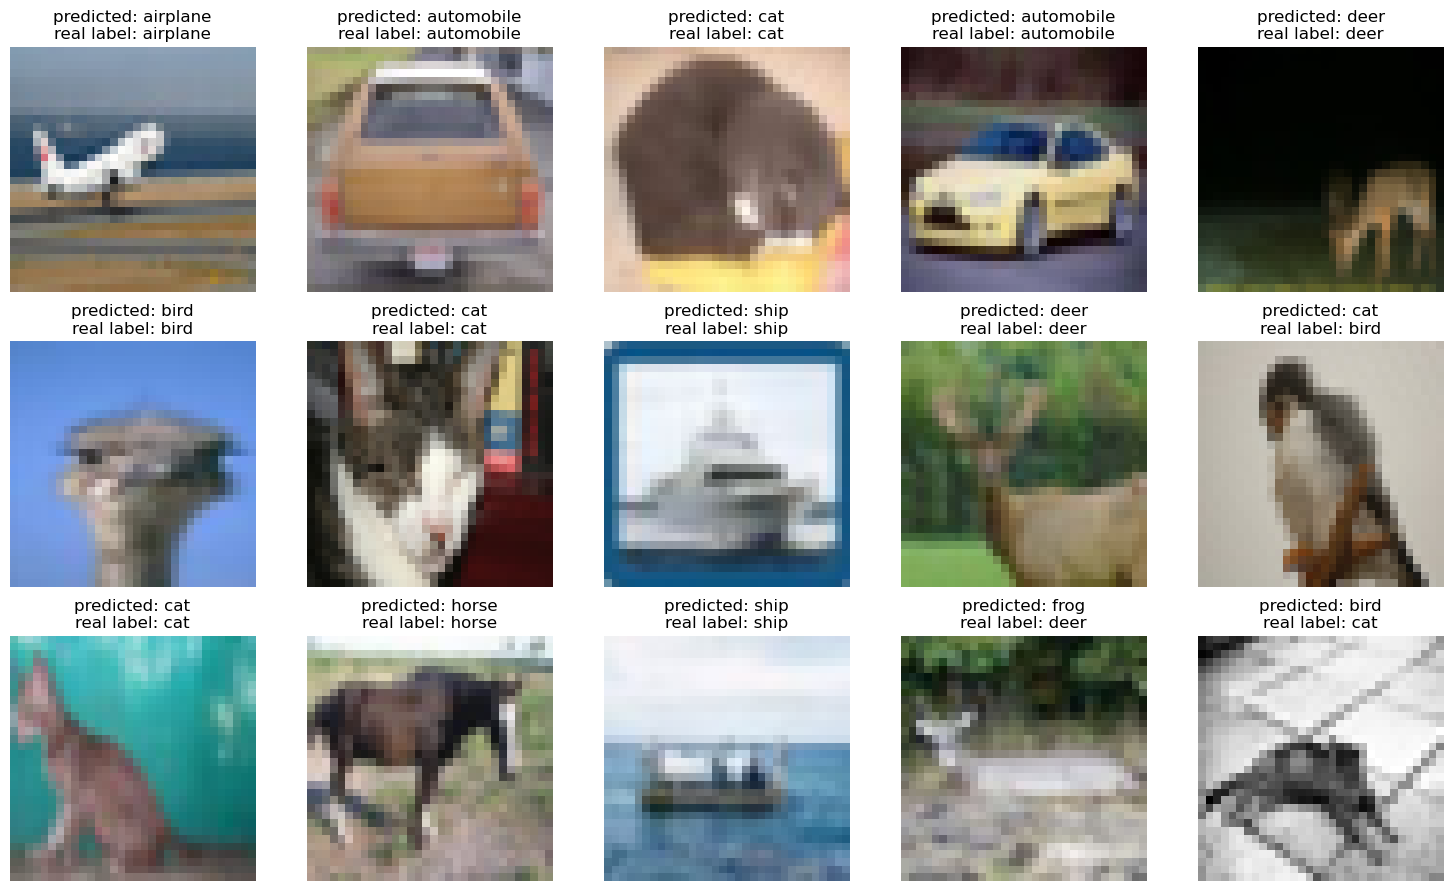

In [14]:
visualize_predictions(model)

In [20]:
def history_plot(history):
    plt.plot(history.history["accuracy"])
    plt.plot(history.history["val_accuracy"])
    plt.legend(["accuracy", "val_accuracy"])
    plt.grid()
    plt.title("Accuracy")
    plt.show()
    plt.legend(["loss", "val_loss"])
    plt.title("Loss")
    plt.plot(history.history["loss"])
    plt.plot(history.history["val_loss"])
    plt.grid()
    plt.show()

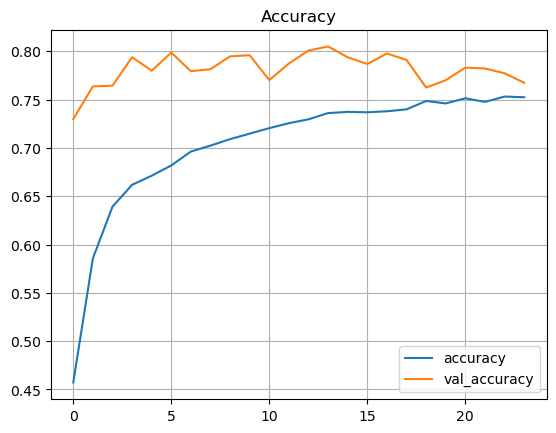

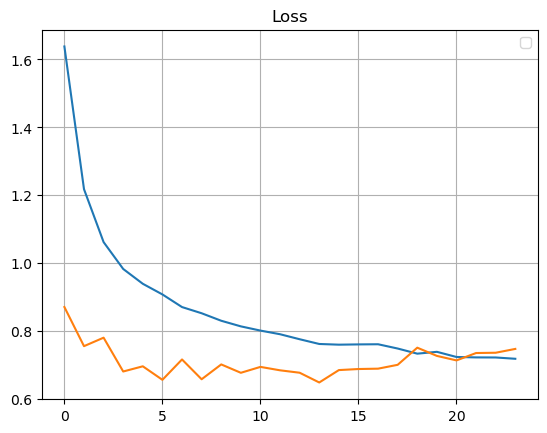

In [21]:
history_plot(history)

In [25]:
%tensorboard --logdir logs/fit

Reusing TensorBoard on port 6006 (pid 13980), started 0:12:19 ago. (Use '!kill 13980' to kill it.)